# Pokemon - Defense to Weight/Height Correlation
**Description**: Is there a correlation between a Pokemon's Defense stat and it's height or weight?

<img src="https://github.com/Mushtatoes/proj/blob/master/pikachu.png?raw=true" width="300"/>


---
- Defense is one of the primary stats used during combat in Pokemon. It is one of the fundamental values used in the core combative gameplay of Pokemon.<br>
- Weight and Height are go more or less unnoticed in Pokemon games. They're mostly fun facts that exist in the Pokedex. It's highly unlikely that developers look at Defense and Weight/Height in parallel when creating Pokemon.<br>
- There are Pokemon like Onix and Steelix, both of which have positively correlated Defense and Weight or Height, but then there are Pokemon like Shuckle...a tiny and light Pokemon with even higher Defense than the two mentioned.<br>
- This study will calculate the correlation coefficient between Defense and Weight and determine if these properties have any relationship with each other.




In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re
import scipy.stats as stats

## 1. Obtaining Data


- No mega-evolutions, alternate forms, etc.
- Pulling from PokeAPI
- Manually parse and add data into Dataframe without using read_json
- At time of writing, there are currently 807 unique Pokemon in the API (Up to Gen 7)




In [0]:
pokemon_json = requests.get('https://pokeapi.co/api/v2/pokemon?&limit=5000').json()
# print(pokemon_json)

#### 1a. Filter out non-standard Pokemon by id
- Create a list of urls that can be used to pull data on each Pokemon.
- PokeAPI uses id <= 10000 to identify standard Pokemon and their traits.
- Use regular expressions to isolate the id from the url and compare.

In [0]:
name_url_raw = pokemon_json['results']

# Filter out non-standard Pokemon using regex on url:
def pokemon_filter(pokemon_object):
  pokemon_search = re.search('^https://pokeapi\.co/api/v2/pokemon/(\d+)/$', pokemon_object['url'])
  if not pokemon_search:
    return False
  return int(pokemon_search.group(1)) <= 10000

name_url = list(filter(pokemon_filter, name_url_raw))

pokemon_urls = [x['url'] for x in name_url]


#### 1b. Map the required data
- Each Pokemon's base stats can only be found on their own page, which means a request for each Pokemon.
- Storing into a flat file or SQL table would be preferable if the data is  required for reuse in the future.

In [0]:
# Return each pokemon's name, type1, and base stats:
def pokemon_map(url):
  pokemon = requests.get(url).json()
  data = {'name': pokemon['name']
          ,'type1': ''.join([t['type']['name'] for t in pokemon['types'] if t['slot'] == 1])
          ,'stats': {s['stat']['name']: s['base_stat']for s in pokemon['stats']}
          ,'weight': pokemon['weight']
          ,'height': pokemon['height']
          }
  return data

# Type1 and stats are not required here: pulled in the case this data needs to be re-used for other tests 
pokemon_data = list(map(pokemon_map, pokemon_urls))

#print(pokemon_data)

#### 1c. Push the data into a pandas DataFrame

In [5]:
# Format data into dictionaries for DataFrame:
# {Header: [data]}

def pivot_data(category, subcategory = None):
  if not subcategory:
    return [pokemon[category] for pokemon in pokemon_data]
  else:
    return [pokemon[category][subcategory] for pokemon in pokemon_data]

pokemon_name = pivot_data('name')
pokemon_type = pivot_data('type1')
pokemon_spd = pivot_data('stats', 'speed')
pokemon_spdef = pivot_data('stats', 'special-defense')
pokemon_spatk = pivot_data('stats', 'special-attack')
pokemon_def = pivot_data('stats', 'defense')
pokemon_atk = pivot_data('stats', 'attack')
pokemon_hp = pivot_data('stats', 'hp')
pokemon_weight = pivot_data('weight')
pokemon_height = pivot_data('height')

pokemon_df = pd.DataFrame({'Name': pokemon_name
                           ,'Type1': pokemon_type
                           ,'SPD': pokemon_spd
                           ,'SPDEF': pokemon_spdef
                           ,'SPATK': pokemon_spatk
                           ,'DEF': pokemon_def
                           ,'ATK': pokemon_atk
                           ,'HP': pokemon_hp
                           ,'Weight': pokemon_weight
                           ,'Height': pokemon_height
                           })

# Display top rows from DataFrame for preview:

pokemon_df.head()

,Name,Type1,SPD,SPDEF,SPATK,DEF,ATK,HP,Weight,Height
0,bulbasaur,grass,45,65,65,49,49,45,69,7
1,ivysaur,grass,60,80,80,63,62,60,130,10
2,venusaur,grass,80,100,100,83,82,80,1000,20
3,charmander,fire,65,50,60,43,52,39,85,6
4,charmeleon,fire,80,65,80,58,64,58,190,11


## 2. Testing the Relationships



#### 2a. Viewing and Calculating Data
Test the impact of each pokemon property versus it's Defense stat:
 - DEF vs. Weight
 - DEF vs. Height
 - Weight vs. Height

Let's see how each set looks on separate plots:


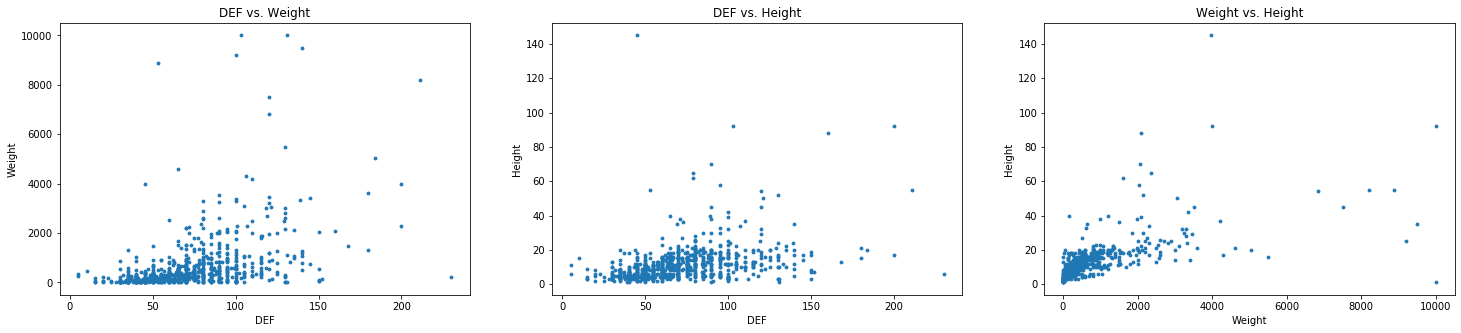

In [6]:
fig, ax = plt.subplots(1,3, figsize = (25, 5))

def scatter_grapher(df, i, prop_x, prop_y):
  ax[i].scatter(df[prop_x], df[prop_y], s = 8)
  ax[i].set_title(prop_x + ' vs. ' + prop_y)
  ax[i].set_xlabel(prop_x)
  ax[i].set_ylabel(prop_y)

scatter_grapher(pokemon_df, 0, 'DEF', 'Weight')
scatter_grapher(pokemon_df, 1, 'DEF', 'Height')
scatter_grapher(pokemon_df, 2, 'Weight', 'Height')

plt.show()

We'll use Pearson's Correlation Coefficient to determine the p-values.

Normally we would calculate:
- Mean and standard deviation of each property
- Covariance
- Divide by the product of the standard deviation of each property
- Use a critical value table to find the p-value

But we get summarize that all into one step by using the scipy library.

State our null hypothesis and alternative hypothesis:
> H<sub>0</sub> : r = 0<br>
>H<sub>1</sub>: r ≠ 0

Where r = 0 indicates there is no correlation and r ≠ 0 indicates there is some type of correlation.

And we will use the standard significance level of 0.05:

> α = 0.05

#### 2b. Calculating the Correlation Coefficient

We can compare the how much each property is related each other using the correlation coefficient, denoted by ρ (rho).
> - +1 = Positive Correlation
- 0 = No Correlation
--1 = Negative Correlation

Let's use the scipy library to calculate Pearson's Correlation Coefficient and p-value:

In [7]:
# Creating a DataFrame to hold results mainly for aesthetic:
results_coef = []
results_pval = []

def_weight = stats.pearsonr(pokemon_df['DEF'], pokemon_df['Weight'])
def_height = stats.pearsonr(pokemon_df['DEF'], pokemon_df['Height'])
weight_height = stats.pearsonr(pokemon_df['Weight'], pokemon_df['Height'])

# Rounding and appending, just to improve readability.
def round_ins(t):
  results_coef.append(round(t[0],2))
  results_pval.append(round(t[1],2))

round_ins(def_weight)
round_ins(def_height)
round_ins(weight_height)

results_columns = {'Properties': ['corr (DEF, Weight)', 'corr (DEF, Height)', 'corr (Weight, Height)'], 'r': results_coef, 'p-value': results_pval}

results_df = pd.DataFrame(results_columns)

results_df

,Properties,r,p-value
0,"corr (DEF, Weight)",0.45,0.0
1,"corr (DEF, Height)",0.36,0.0
2,"corr (Weight, Height)",0.64,0.0


#### 2c. Thoughts and Analysis

**All Pokemon**<br>
**corr (DEF, Weight), corr (DEF, Height), corr (Weight, Height):**

Since r ≠ 0 for all three correlation coefficients, we can reject the null hypothesis and assume there is correlation between all three properties. The p-value is also very low (\< 0.001): further indicating strong evidence against the null hypothesis and well within the significant value α.

- Weight and Height, both which are less important to gameplay and more arbitrary properties in the Pokemon universe, have a higher correlation coefficient than the other two tests. It does make logical sense that the taller a Pokemon in canon, the heavier it becomes and that these two properties have a higher correlation coefficient than corr (DEF, Weight) or corr (DEF, Height).

- Another reason the Weight & Height correlation coefficient may be higher is because those two values likely come from the same source: the Pokemon creators. DEF is a combat stat used in core gameplay, so it has to be balanced and maintained based on how the game developers feel fit, while Weight and Height have a very low impact on the core gameplay.

## 3. Filtering by Type

The analysis in section 2 was used with all Pokemon that currently exist in the PokeAPI (Gen 7).

Let's find the top Defense-based Pokemon type and use it for correlation anaylsis.

- There are currently 18 types of Pokemon.
- Only Type1 will be used, as that is the Pokemon's primary type.
- Find the top type where DEF is the highest stat per Pokemon.

#### 3a. Creating a new DataFrame for DEF-based Pokemon

In [8]:
def def_bin(row):
  return pokemon_df.DEF.iloc[row] == pokemon_df[['SPD','SPDEF','SPATK','DEF','ATK','HP']].iloc[row].max()

pokemon_df['def_hi'] = [def_bin(pokemon) for pokemon in range(pokemon_df.Name.count()) if True]

def_pokemon_df = pokemon_df[pokemon_df.def_hi == True]

def_pokemon_df

,Name,Type1,SPD,SPDEF,SPATK,DEF,ATK,HP,Weight,Height,def_hi
6,squirtle,water,43,64,50,65,48,44,90,5,True
7,wartortle,water,58,80,65,80,63,59,225,10,True
10,metapod,bug,30,25,25,55,20,50,99,7,True
13,kakuna,bug,35,25,25,50,25,45,100,6,True
26,sandshrew,ground,40,30,20,85,75,50,120,6,True
...,...,...,...,...,...,...,...,...,...,...,...
782,hakamo-o,dragon,65,70,65,90,75,55,470,12,True
783,kommo-o,dragon,85,105,100,125,110,75,782,16,True
789,cosmoem,psychic,37,131,29,131,29,43,9999,1,True
793,buzzwole,bug,79,53,53,139,139,107,3336,24,True


Now that we have all the Defense-based Pokemon, not all types have the same number of Pokemon, so the proportion of Pokemon that are Defense-based per type will be taken out of all Pokemon per type.

- If there are other stats equal to DEF as the highest, they are still counted as a Defense Pokemon.

In [9]:
# (Count of DEF Highest Base stat Pokemon / Count of all Pokemon) per Type
tot_count = pokemon_df.groupby('Type1').count()
def_count = def_pokemon_df.groupby('Type1').count()

df_prop = pd.DataFrame(round(def_count['Name'] / tot_count['Name'], 2))

# Rename column Name -> Proportion to avoid confusion
rename_df = df_prop.rename(columns = {'Name': 'Proportion'})

def_type_prop = rename_df.reset_index()

def_type_prop

,Type1,Proportion
0,bug,0.33
1,dark,0.10
2,dragon,0.19
3,electric,NaN
4,fairy,0.17
5,fighting,0.03
6,fire,0.06
7,flying,NaN
8,ghost,0.37
9,grass,0.21


#### 3b. Determining which Type to Test

Plot on a bar graph so that the highest proportion of defense-based Pokemon types can easily be compared.

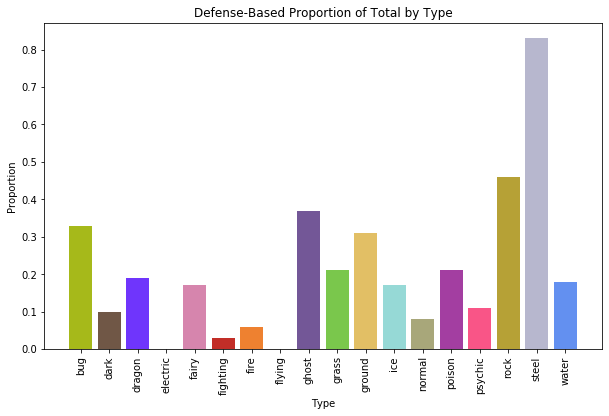

In [10]:
# HTML color codes for each type
type_colors = {'bug': '#A6B91A', 'dark': '#705746', 'dragon': '#6F35FC', 'electric': '#F7D02C', 'fairy': '#D685AD', 'fighting': '#C22E28'
, 'fire': '#EE8130', 'flying': '#A98FF3', 'ghost': '#735797', 'grass': '#7AC74C', 'ground': '#E2BF65', 'ice': '#96D9D6'
, 'normal': '#A8A77A', 'poison': '#A33EA1', 'psychic': '#F95587', 'rock': '#B6A136', 'steel': '#B7B7CE', 'water': '#6390F0'}

# Set x/y positions and create labels
x = range(def_type_prop.Type1.count())
y = def_type_prop.Proportion
xlabels = list(def_type_prop.Type1)

plt.figure(figsize = (10,6))
plt.bar(x, y, color = type_colors.values())
plt.xticks(x, xlabels, rotation = 90)
plt.xlabel('Type')
plt.ylabel('Proportion')
plt.title('Defense-Based Proportion of Total by Type')

plt.show()

#### 3c. Calculating the Correlation Coefficient for Steel types

We can see that Steel has a resounding top proportion of Defense based Pokemon, with Rock coming in second and Ghost coming in third.

- Note that ghost types have the third highest proportion of Defense-based Pokemon.
- Most ghost Pokemon have little to no Weight, which could have been part of the reason why the DEF to Weight correlation coefficient was moderate.
- Keep in mind these are primary types only.

Plotting Steel Pokemon for the same properties tested earlier:

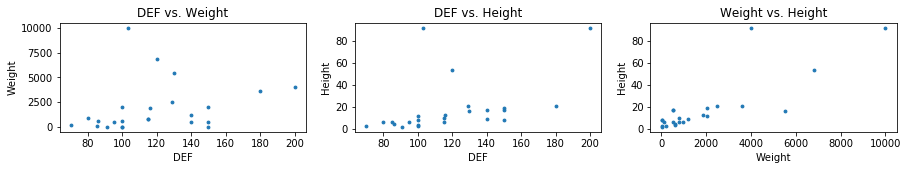

In [11]:
steel_df = pokemon_df[pokemon_df.Type1 == 'steel']

fig, ax = plt.subplots(1,3, figsize = (15,2))

scatter_grapher(steel_df, 0, 'DEF', 'Weight')
scatter_grapher(steel_df, 1, 'DEF', 'Height')
scatter_grapher(steel_df, 2, 'Weight', 'Height')

plt.show()

State null hypothesis and alternative hypothesis:

> H<sub>0</sub> : r = 0<br>
>H<sub>1</sub>: r ≠ 0

Where r (rho) = 0 indicates there is no correlation and r ≠ 0 indicates there is some correlation. 

And we will use the standard significance level of 0.05:

> α = 0.05


Let's calculate the correlation coefficients for steel type pokemon:

In [12]:
# Same as for all Pokemon, except with steel prefix
steel_results_coef = []
steel_results_pval = []

def steel_round_ins(t):
  steel_results_coef.append(round(t[0],2))
  steel_results_pval.append(round(t[1],2))

steel_def_weight = stats.pearsonr(steel_df['DEF'], steel_df['Weight'])
steel_def_height = stats.pearsonr(steel_df['DEF'], steel_df['Height'])
steel_weight_height = stats.pearsonr(steel_df['Weight'], steel_df['Height'])

steel_round_ins(steel_def_weight)
steel_round_ins(steel_def_height)
steel_round_ins(steel_weight_height)

steel_results_columns = {'Properties': ['corr (DEF, Weight)', 'corr (DEF, Height)', 'corr (Weight, Height)'], 'r': steel_results_coef, 'p-value': steel_results_pval}

steel_results_df = pd.DataFrame(steel_results_columns)

print('Steel Only:')
display(steel_results_df)
print()
print('All Pokemon:')
display(results_df)


Steel Only:


,Properties,r,p-value
0,"corr (DEF, Weight)",0.25,0.23
1,"corr (DEF, Height)",0.45,0.03
2,"corr (Weight, Height)",0.81,0.00



All Pokemon:


,Properties,r,p-value
0,"corr (DEF, Weight)",0.45,0.0
1,"corr (DEF, Height)",0.36,0.0
2,"corr (Weight, Height)",0.64,0.0


**Steel Type Only** 

**corr (DEF, Weight):** 

Although r ≠ 0, the p-value is not within significant value α = 0.05. This is likely due to the small sample size; there are only 24 primary type steel Pokemon. We cannot assume that the value of corr (DEF, Weight) is statistically significant: it's unreliable because the p-value is too high.

**corr (DEF, Height):** 

r ≠ 0 and the p-value is within the significance level of α = 0.05. We reject the null hypothesis and assume that there is correlation between DEF and Height for Steel Pokemon, but not as reliably as when we had all Pokemon since the p-value is higher.

**corr (Weight, Height):** 

Similar to the correlation coefficient for all Pokemon, we can also reject the null hypothesis here. The correlation coefficient is even higher for Steel Pokemon when looking at the relationship between Weight and Height. It can be assumed that steel Pokemon have a stronger Weight and Height correlation than other Pokemon in general.

**Notes:**
- Pokemon like Celesteela, Dialga, Metagross, and Jirachi are outliers that have a significant impact on the data. <br>
- As said before, Pokemon weights and heights are for mostly for canonical purposes and not gameplay purposes. <br>
- Celesteela has 9999 Weight, which translates to half a ton! It seems like the developers were trying to throw a fun fact out for their players by making a Pokemon so heavy!


## **Conclusion** 

We can conclude that there is a moderate correlation between a Pokemon's DEF stat and its Weight or Height.

This translates to Pokemon who are heavier or larger being able to take more punches and kicks in the Pokemon universe.<br>
Of course, this is all fictional and each Pokemon is created individually for a separate purpose.<br>


This is shown by Pokemon like Shuckle completely break this trend:<br>
<img src ="https://github.com/Mushtatoes/proj/blob/master/shuckle.png?raw=true" width = "100" /><br>
This tiny guy is not only light, but has the highest base DEF stat in the Pokemon universe!

This project is mainly to showcase analytical and coding skills. These are statistical assumptions made on Pokemon created by the imaginations of the employees at GameFreak. 
They could create 1000 Pokemon with high DEF and low weight/height, which would completely change these calculations!

Thanks for reading!